**Problem Statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/My Drive/Colab Notebooks/Skin cancer/Train")
data_dir_test = pathlib.Path('/content/drive/My Drive/Colab Notebooks/Skin cancer/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

create a code to visualize one instance of all the nine classes present in the dataset

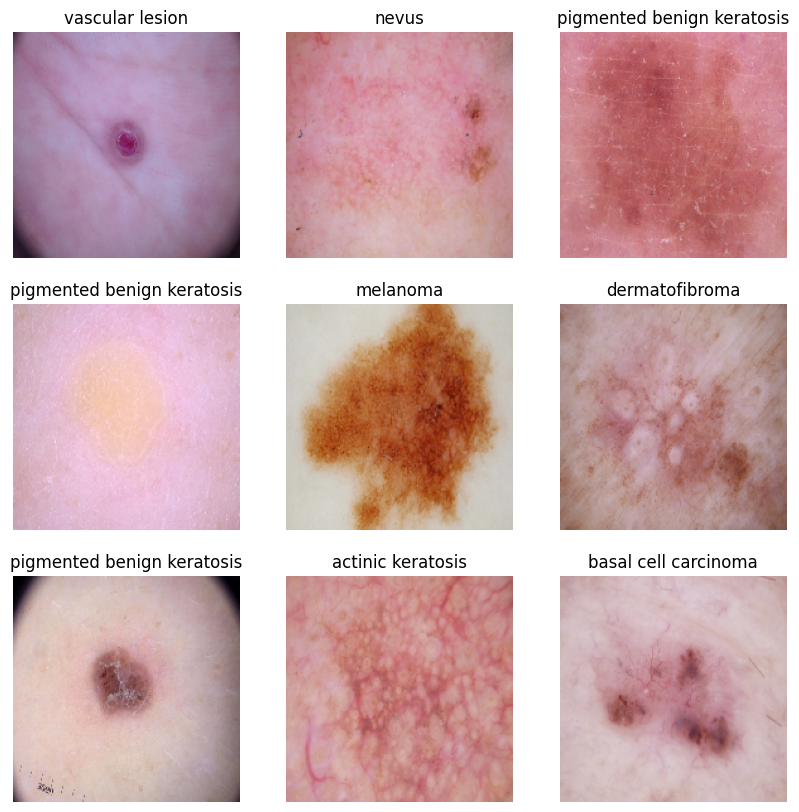

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


The image_batch is a tensor with the shape (32, 180, 180, 3), representing a batch of 32 images of size 180x180x3 (the last dimension refers to the RGB colour channels). The label_batch is a tensor with the shape (32,), representing the corresponding labels for the 32 images.

Dataset.cache() stores the images in memory after they are loaded from disk during the first epoch.

Dataset.prefetch() enables overlapping of data preprocessing with model execution during training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

##**Create the CNN Model**

Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [ ]:
# Initialize the model
model = Sequential()

# Add layers one by one
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

### Compiling the model

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
# View the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

###Training the model

In [ ]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 20s 178ms/step - loss: 2.0091 - accuracy: 0.2612 - val_loss: 1.9091 - val_accuracy: 0.2908
Epoch 2/20
56/56 [==============================] - 6s 108ms/step - loss: 1.7724 - accuracy: 0.3605 - val_loss: 1.6273 - val_accuracy: 0.4049
Epoch 3/20
56/56 [==============================] - 6s 108ms/step - loss: 1.5575 - accuracy: 0.4554 - val_loss: 1.4234 - val_accuracy: 0.5123
Epoch 4/20
56/56 [==============================] - 6s 107ms/step - loss: 1.3842 - accuracy: 0.5011 - val_loss: 1.3766 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 6s 107ms/step - loss: 1.2763 - accuracy: 0.5508 - val_loss: 1.4000 - val_accuracy: 0.5391
Epoch 6/20
56/56 [==============================] - 6s 107ms/step - loss: 1.1878 - accuracy: 0.5887 - val_loss: 1.5061 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 6s 106ms/step - loss: 1.0743 - accuracy: 0.6222 - val_loss: 1.4218 - val_accuracy: 0.4989
Epoch

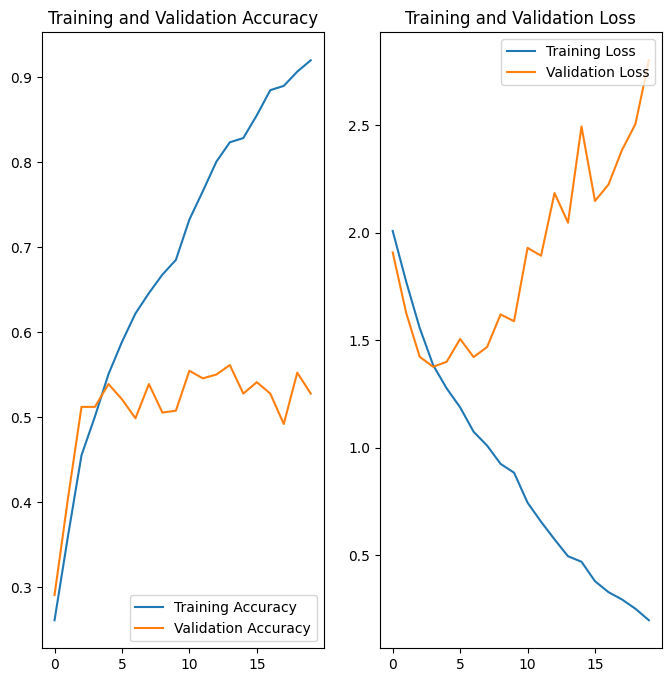

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observations: .

1. The model's training accuracy shows a steady improvement, reaching up to 90%, while the validation accuracy remains consistently around 55%.
2. The high training accuracy suggests that the model has effectively learned patterns within the training data, including potential noise. However, its significantly lower performance on validation data indicates a lack of generalisability.
3. These observations confirm overfitting. To address this, data augmentation techniques, such as image flips and slight rotations, will be applied to generate additional training samples.



In [ ]:
augmentation_data = keras.Sequential([
                                      layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.experimental.preprocessing.RandomRotation(0.1),
                                      layers.experimental.preprocessing.RandomZoom(0.1),
])

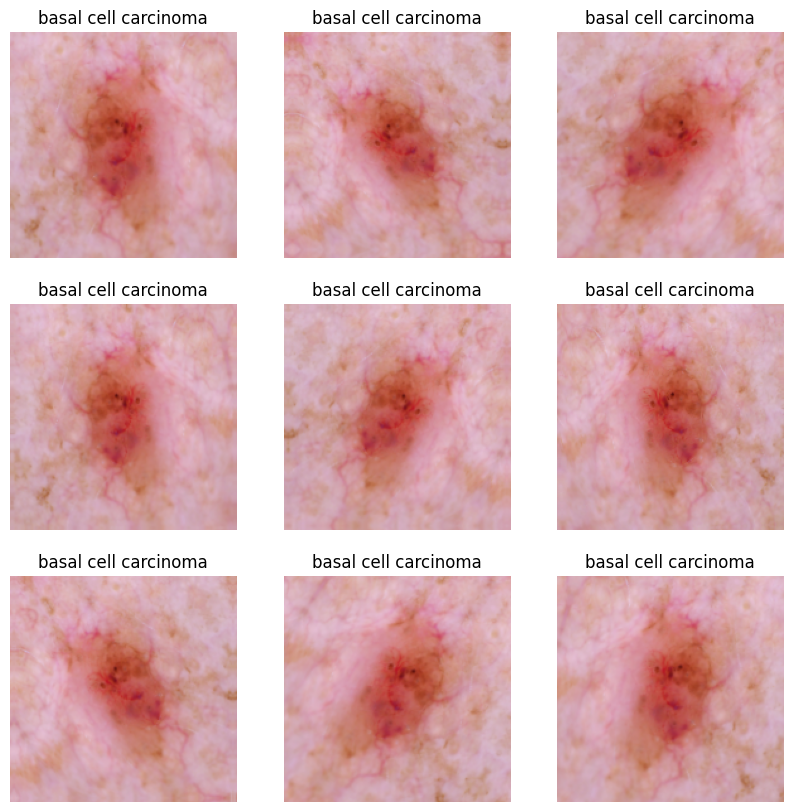

In [ ]:

# Visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

### Create the model

In [ ]:
# Initialize the model
model = Sequential()

model.add(augmentation_data)
# Add layers one by one
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

### Compiling the model

In [ ]:

## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

###Training the model

In [ ]:
%%time
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 8s 121ms/step - loss: 2.0383 - accuracy: 0.2472 - val_loss: 1.8675 - val_accuracy: 0.3333
Epoch 2/20
56/56 [==============================] - 7s 118ms/step - loss: 1.8213 - accuracy: 0.3287 - val_loss: 1.7260 - val_accuracy: 0.3803
Epoch 3/20
56/56 [==============================] - 7s 120ms/step - loss: 1.6759 - accuracy: 0.3923 - val_loss: 1.5890 - val_accuracy: 0.4362
Epoch 4/20
56/56 [==============================] - 7s 118ms/step - loss: 1.5119 - accuracy: 0.4671 - val_loss: 1.4634 - val_accuracy: 0.5056
Epoch 5/20
56/56 [==============================] - 7s 118ms/step - loss: 1.4075 - accuracy: 0.5000 - val_loss: 1.4096 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 7s 118ms/step - loss: 1.3502 - accuracy: 0.5201 - val_loss: 1.3480 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 6s 116ms/step - loss: 1.3248 - accuracy: 0.5285 - val_loss: 1.3743 - val_accuracy: 0.5526
Epoch 8/20
56/56 

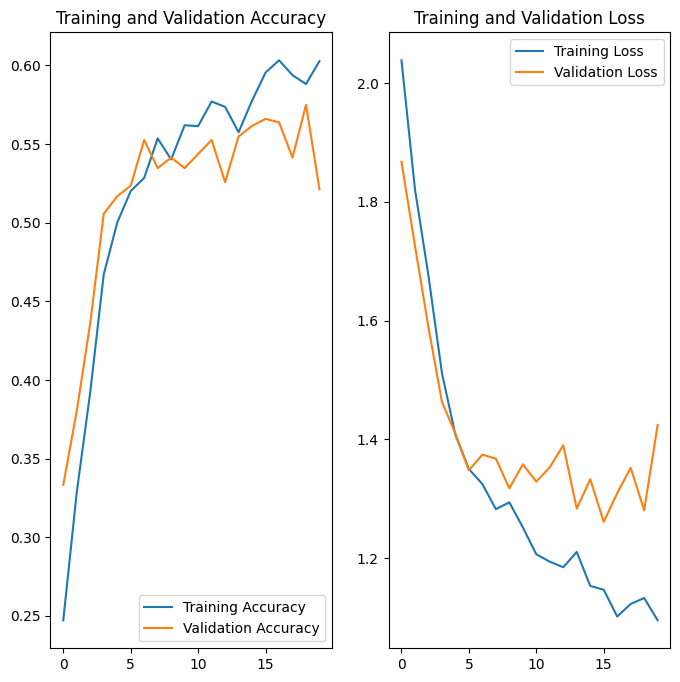

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observations: .

1. The model shows steady improvement in training accuracy, but validation accuracy fluctuates and remains lower.
2. Training loss decreases steadily, but validation loss fluctuates and increases, indicating poor generalisation.
3. Both the training and validation data are showing poor performance, indicating that the model is now exhibiting underfitting.



Find the distribution of classes in the training dataset.

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [ ]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/drive/My Drive/Colab Notebooks/Skin cancer/Train/dermatofibroma/ISIC_0026313.jpg', 'dermatofibroma'), ('/content/drive/My Drive/Colab Notebooks/Skin cancer/Train/dermatofibroma/ISIC_0025911.jpg', 'dermatofibroma'), ('/content/drive/My Drive/Colab Notebooks/Skin cancer/Train/dermatofibroma/ISIC_0025622.jpg', 'dermatofibroma'), ('/content/drive/My Drive/Colab Notebooks/Skin cancer/Train/dermatofibroma/ISIC_0025771.jpg', 'dermatofibroma'), ('/content/drive/My Drive/Colab Notebooks/Skin cancer/Train/dermatofibroma/ISIC_0025668.jpg', 'dermatofibroma')]


In [ ]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,/content/drive/My Drive/Colab Notebooks/Skin c...,dermatofibroma
1,/content/drive/My Drive/Colab Notebooks/Skin c...,dermatofibroma
2,/content/drive/My Drive/Colab Notebooks/Skin c...,dermatofibroma
3,/content/drive/My Drive/Colab Notebooks/Skin c...,dermatofibroma
4,/content/drive/My Drive/Colab Notebooks/Skin c...,dermatofibroma


In [ ]:
## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


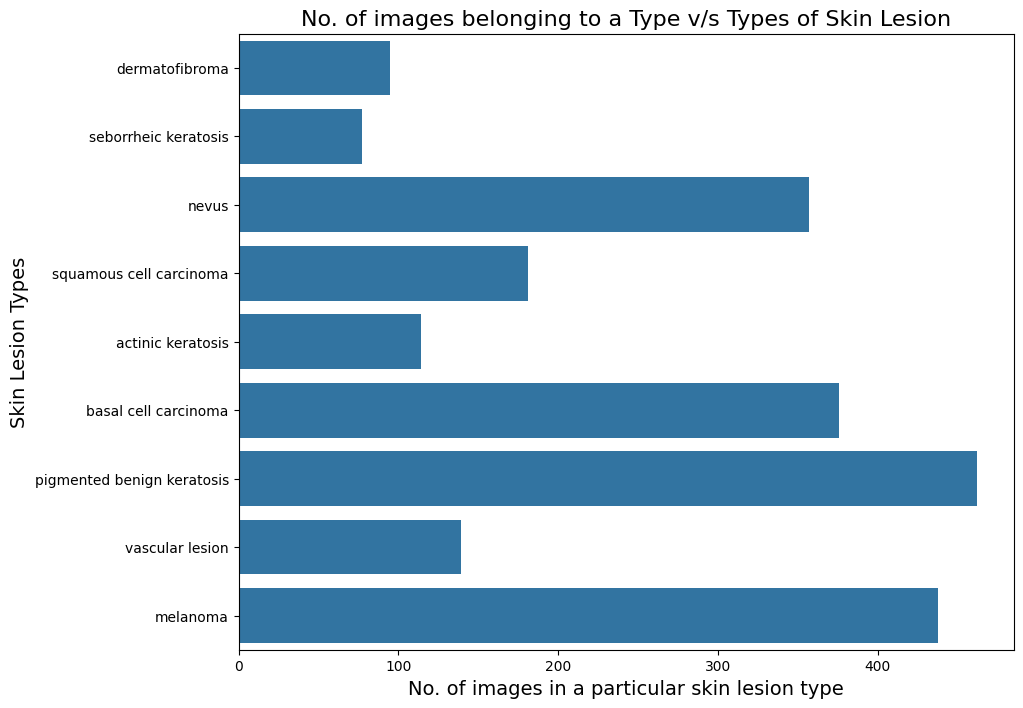

In [ ]:
# Visualize the distribution of classes using a countplot

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

In [ ]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,20.63
melanoma,19.56
basal cell carcinoma,16.79
nevus,15.94
squamous cell carcinoma,8.08
vascular lesion,6.21
actinic keratosis,5.09
dermatofibroma,4.24
seborrheic keratosis,3.44


Write your findings here:
- Which class has the least number of samples?
- Which classes dominate the data in terms proportionate number of samples?

Observations:

1. A clear class imbalance is evident within the training data.

2. The class "**seborrheic keratosis**" comprises the smallest proportion of samples, accounting for approximately **3.44%.**

3. "**Pigmented benign keratosis**" and "**melanoma**" significantly outweigh other classes, representing approximately **20.63%** and **19.56%** of the data, respectively.

Rectify the class imbalance

Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.
2. Define a number of operations to perform on this data set using your Pipeline object.
3. Execute these operations by calling the Pipeline’s sample() method.

In [ ]:
path_to_training_dataset=  str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Skin cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D3A000CF550>: 100%|██████████| 500/500 [00:04<00:00, 105.33 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Skin cancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D38FC5B6590>: 100%|██████████| 500/500 [00:04<00:00, 106.19 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Skin cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D38FC5202B0>: 100%|██████████| 500/500 [00:04<00:00, 108.18 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Skin cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D390C7C36D0>: 100%|██████████| 500/500 [00:06<00:00, 74.76 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Skin cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2565x2000 at 0x7D3A000E7E50>: 100%|██████████| 500/500 [00:06<00:00, 74.95 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Skin cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D3974616050>: 100%|██████████| 500/500 [00:05<00:00, 96.37 Samples/s] 


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Skin cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D4117030970>: 100%|██████████| 500/500 [00:04<00:00, 103.45 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Skin cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D39746165F0>: 100%|██████████| 500/500 [00:04<00:00, 104.68 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Skin cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D3974191E40>: 100%|██████████| 500/500 [00:04<00:00, 102.98 Samples/s]


In [ ]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [ ]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/drive/My Drive/Colab Notebooks/Skin cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025594.jpg_f6999aee-8887-46db-8c54-9aa5945167e0.jpg',
 '/content/drive/My Drive/Colab Notebooks/Skin cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025302.jpg_040dc23e-554e-49c9-8ba0-5a12f1453175.jpg',
 '/content/drive/My Drive/Colab Notebooks/Skin cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031735.jpg_168c8d8b-e24b-46fc-a040-ad086cc58947.jpg',
 '/content/drive/My Drive/Colab Notebooks/Skin cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029052.jpg_c98ee23d-1ebe-4086-be6e-0db041c4752e.jpg',
 '/content/drive/My Drive/Colab Notebooks/Skin cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028790.jpg_69d0a232-dee5-4cec-8777-9917b66a424e.jpg']

In [ ]:

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma']

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
# Use pd.concat instead of append
new_df = pd.concat([lesions_df, df2], ignore_index=True)

# Check the shape of the new dataframe
new_df.shape

(6739, 2)

In [ ]:
# View the augmented image paths and labels in a new df
new_df.head()

,Image Path,Label
0,/content/drive/My Drive/Colab Notebooks/Skin c...,dermatofibroma
1,/content/drive/My Drive/Colab Notebooks/Skin c...,dermatofibroma
2,/content/drive/My Drive/Colab Notebooks/Skin c...,dermatofibroma
3,/content/drive/My Drive/Colab Notebooks/Skin c...,dermatofibroma
4,/content/drive/My Drive/Colab Notebooks/Skin c...,dermatofibroma


In [ ]:
# Inspecting the classes after adding 500 samples per label
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


In [ ]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(new_df['Label'].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,14.28
melanoma,13.92
basal cell carcinoma,13.00
nevus,12.72
squamous cell carcinoma,10.11
vascular lesion,9.48
actinic keratosis,9.11
dermatofibroma,8.83
seborrheic keratosis,8.56


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training dataset

In [ ]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create your model (make sure to include normalization)

In [ ]:
model = Sequential()

# Data augmentation and normalization layers
model.add(augmentation_data)
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))


### Compiling the model

In [ ]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [ ]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 36s 199ms/step - loss: 2.3979 - accuracy: 0.3336 - val_loss: 26.5387 - val_accuracy: 0.1084
Epoch 2/20
169/169 [==============================] - 33s 195ms/step - loss: 1.5735 - accuracy: 0.4138 - val_loss: 6.0152 - val_accuracy: 0.1863
Epoch 3/20
169/169 [==============================] - 33s 193ms/step - loss: 1.3950 - accuracy: 0.4635 - val_loss: 1.9465 - val_accuracy: 0.3979
Epoch 4/20
169/169 [==============================] - 33s 194ms/step - loss: 1.3386 - accuracy: 0.4829 - val_loss: 2.1667 - val_accuracy: 0.3890
Epoch 5/20
169/169 [==============================] - 33s 191ms/step - loss: 1.2282 - accuracy: 0.5202 - val_loss: 1.8240 - val_accuracy: 0.3979
Epoch 6/20
169/169 [==============================] - 33s 192ms/step - loss: 1.2195 - accuracy: 0.5302 - val_loss: 1.6645 - val_accuracy: 0.4395
Epoch 7/20
169/169 [==============================] - 33s 192ms/step - loss: 1.1423 - accuracy: 0.5632 - val_loss: 1.2018 - val_a

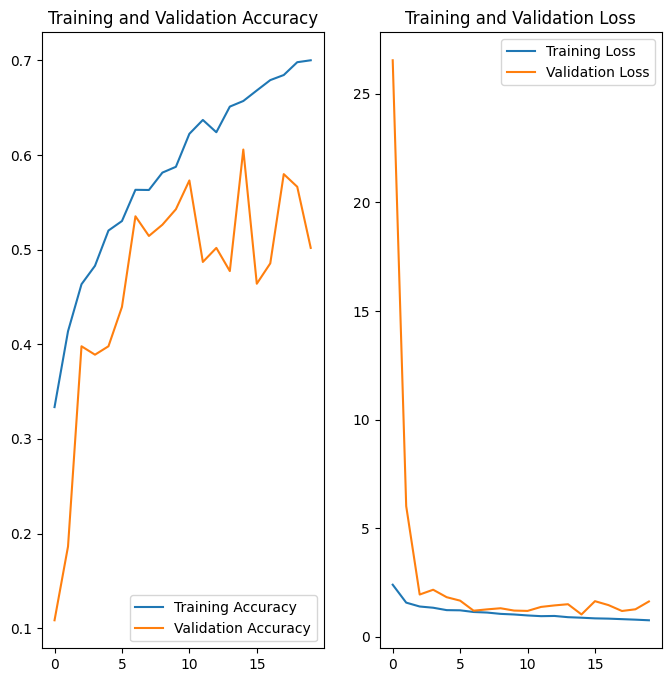

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

  Observations: .

  1. The training accuracy steadily improves, reaching around 70%, while validation accuracy fluctuates significantly.
  2. Formulating an alternative model without batch normalization to explore potential accuracy improvements.



### Creating another model (without batch normalization)

In [ ]:
model = Sequential()

# Data augmentation and normalization layers
model.add(augmentation_data)
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))


### Compiling the model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ModelCheckpoint callback is employed alongside the model.fit() training process to periodically save the model
# or its weights (in a checkpoint file)
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Early stop the training when a monitored metric ceases to show improvement
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

### Training the model

In [ ]:
%%time
# train the model
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - ETA: 0s - loss: 1.8792 - accuracy: 0.2787
Epoch 1: val_accuracy improved from -inf to 0.38530, saving model to model.keras
169/169 [==============================] - 24s 129ms/step - loss: 1.8792 - accuracy: 0.2787 - val_loss: 1.5743 - val_accuracy: 0.3853
Epoch 2/50
169/169 [==============================] - ETA: 0s - loss: 1.5184 - accuracy: 0.4139
Epoch 2: val_accuracy improved from 0.38530 to 0.43727, saving model to model.keras
169/169 [==============================] - 22s 129ms/step - loss: 1.5184 - accuracy: 0.4139 - val_loss: 1.4489 - val_accuracy: 0.4373
Epoch 3/50
169/169 [==============================] - ETA: 0s - loss: 1.4079 - accuracy: 0.4633
Epoch 3: val_accuracy improved from 0.43727 to 0.46028, saving model to model.keras
169/169 [==============================] - 22s 128ms/step - loss: 1.4079 - accuracy: 0.4633 - val_loss: 1.3900 - val_accuracy: 0.4603
Epoch 4/50
169/169 [==============================] - ETA: 0s - loss: 1.

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 89, 89, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 43, 43, 32)        0         
 ng2D)                                                

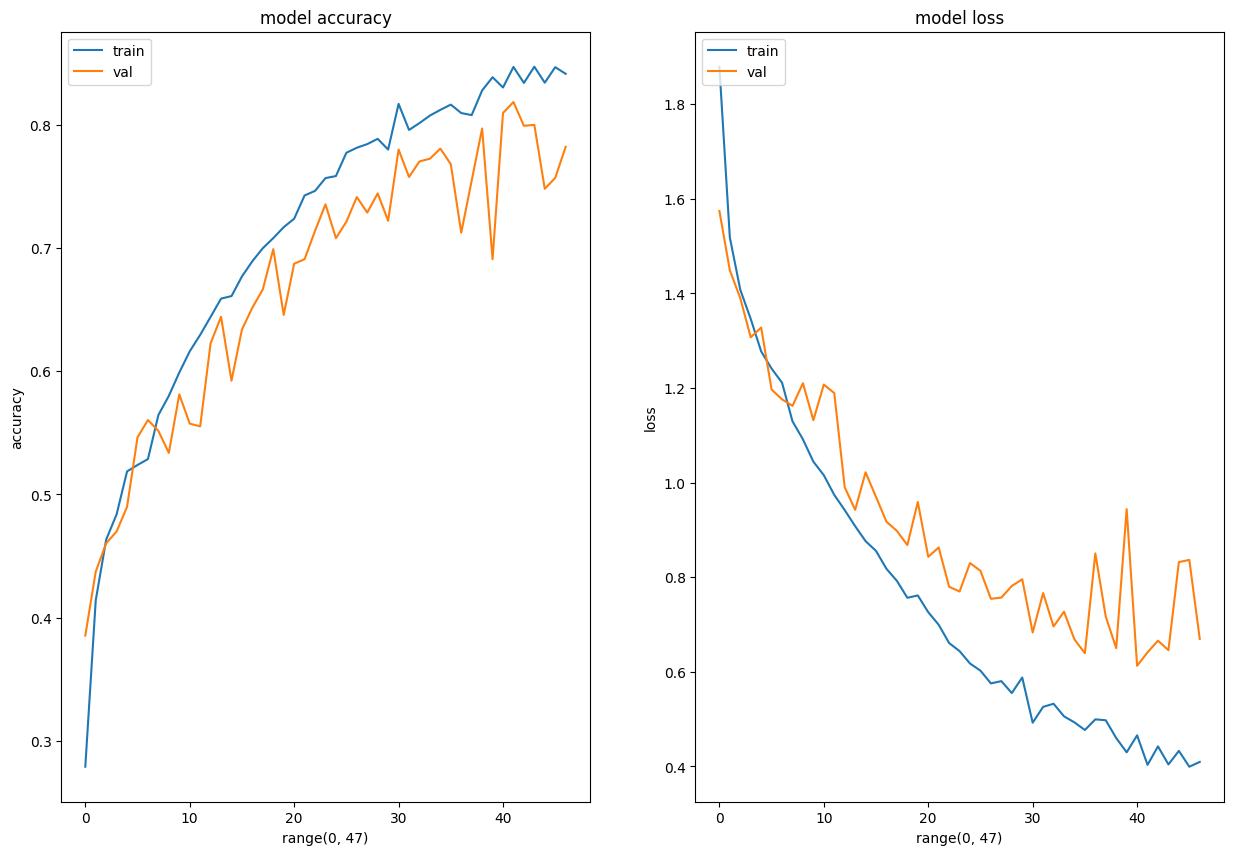

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Observations for the model without batch normalization:

1. The training and validation accuracy show steady improvement, with the model achieving around 84% on training and 81% on validation by the end of training.
2. Training loss decreases consistently, and validation loss also shows a downward trend, though with some fluctuations, indicating effective learning.
3. There is a small gap between training and validation performance, suggesting good generalisation and minimal overfitting.
4. The model demonstrates strong overall performance, with validation accuracy reaching 81%.

### Model Evaluation

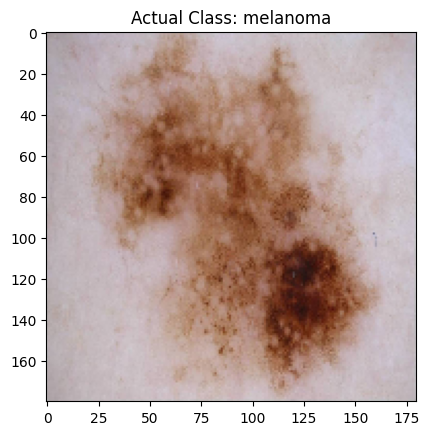

1/1 [==============================] - 0s 28ms/step
Actual Class: melanoma
Predicted Class: melanoma


In [ ]:
import random
from tensorflow.keras.preprocessing.image import load_img

# Select a random class from the test dataset
random_class = random.choice(class_names)

# Get all image paths in the selected class
image_path_test = os.path.join(data_dir_test, random_class, '*')
test_image_paths = glob(image_path_test)

# Select a random image from the selected class
random_image_path = random.choice(test_image_paths)

# Load the image
test_image = load_img(random_image_path, target_size=(180, 180, 3))
plt.imshow(test_image)
plt.title(f"Actual Class: {random_class}")
plt.grid(False)
plt.show()

# Preprocess the image
img = np.expand_dims(test_image, axis=0)

# Get the model's prediction
predicted = model.predict(img)
predicted_class = class_names[np.argmax(predicted)]

# Output the actual and predicted classes
print(f"Actual Class: {random_class}")
print(f"Predicted Class: {predicted_class}")
